In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import robust_scene_change_detect.models as models

from py_utils import utils_img, utils_torch

---
new data

In [ ]:
root = "./google_map_screenshots"

t0_0 = plt.imread(os.path.join(root, "00.2013.03.png"))[..., :3]
t1_0 = plt.imread(os.path.join(root, "00.2024.07.png"))[..., :3]

t0_1 = plt.imread(os.path.join(root, "01.2013.02.png"))[..., :3]
t1_1 = plt.imread(os.path.join(root, "01.2023.05.png"))[..., :3]

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(t0_0)
ax[0, 1].imshow(t1_0)
ax[1, 0].imshow(t0_1)
ax[1, 1].imshow(t1_1)

ax[0, 0].set_title("00.2013.03")
ax[0, 1].set_title("00.2024.07")
ax[1, 0].set_title("01.2013.02")
ax[1, 1].set_title("01.2023.05")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

In [ ]:
roi = np.load(os.path.join(root, "roi.npy"))

kwargs = {
    "layer": [1, 1, 1],  # white color
    "ratio": 0.3,
    "mask": roi,
}

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(utils_img.overlay_image(t0_0, **kwargs))
ax[0, 1].imshow(utils_img.overlay_image(t1_0, **kwargs))
ax[1, 0].imshow(utils_img.overlay_image(t0_1, **kwargs))
ax[1, 1].imshow(utils_img.overlay_image(t1_1, **kwargs))

ax[0, 0].set_title("00.2013.03")
ax[0, 1].set_title("00.2024.07")
ax[1, 0].set_title("01.2013.02")
ax[1, 1].set_title("01.2023.05")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

In [ ]:
kwargs = {
    "layer": [0, 0, 0],  # black color
    "ratio": 0.0,
    "mask": roi,
}

masked_t0_0 = utils_img.overlay_image(t0_0, **kwargs)
masked_t1_0 = utils_img.overlay_image(t1_0, **kwargs)
masked_t0_1 = utils_img.overlay_image(t0_1, **kwargs)
masked_t1_1 = utils_img.overlay_image(t1_1, **kwargs)

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(masked_t0_0)
ax[0, 1].imshow(masked_t1_0)
ax[1, 0].imshow(masked_t0_1)
ax[1, 1].imshow(masked_t1_1)

ax[0, 0].set_title("00.2013.03")
ax[0, 1].set_title("00.2024.07")
ax[1, 0].set_title("01.2013.02")
ax[1, 1].set_title("01.2023.05")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

In [ ]:
# we have pre-processed the screenshots as dinov2 only accepts 14n * 14m

H, W = masked_t0_0.shape[:2]

print(H, W)
print(H % 14, W % 14)

---
get model

In [ ]:
# ---- Uncomment one of these ----

# main model
model = models.get_model_from_pretrained("dino_2Cross_CMU")
# model = models.get_model_from_pretrained("dino_2Cross_DiffCMU")
# model = models.get_model_from_pretrained("dino_2Cross_PSCD")

# ablation models
# model = models.get_model_from_pretrained("resnet_2Cross_CMU")
# model = models.get_model_from_pretrained("resnet_2Cross_PSCD")

# model = models.get_model_from_pretrained("dino_1Cross_CMU")
# model = models.get_model_from_pretrained("dino_CoAttn_CMU")
# model = models.get_model_from_pretrained("dino_TemporalAttn_CMU")
# model = models.get_model_from_pretrained("dino_MTF_CMU")

# --------------------------------

model = model.eval()

# change upsampling size based on the input image size
model.module.upsample.size = (952, 1918)

In [ ]:
# inference on 00
tensor_0 = torch.from_numpy(masked_t0_0).permute(2, 0, 1).unsqueeze(0)
tensor_0 = tensor_0.float().cuda()

tensor_1 = torch.from_numpy(masked_t1_0).permute(2, 0, 1).unsqueeze(0)
tensor_1 = tensor_1.float().cuda()

with torch.no_grad():
    pred_0 = model(tensor_0, tensor_1)  # 1, H, W, 2
    pred_1 = model(tensor_1, tensor_0)  # 1, H, W, 2

    pred_0 = torch.argmax(pred_0, dim=-1).squeeze().cpu().numpy()
    pred_1 = torch.argmax(pred_1, dim=-1).squeeze().cpu().numpy()

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(masked_t0_0)
ax[0, 1].imshow(masked_t1_0)
ax[1, 0].imshow(utils_img.overlay_image(masked_t0_0, [1, 0, 0], mask=pred_0))
ax[1, 1].imshow(utils_img.overlay_image(masked_t1_0, [1, 0, 0], mask=pred_1))

ax[0, 0].set_title("00.2013.03")
ax[0, 1].set_title("00.2024.07")
ax[1, 0].set_title("change map on 00.2013.03")
ax[1, 1].set_title("change map on 00.2024.07")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

In [ ]:
# inference on 01
tensor_0 = torch.from_numpy(masked_t0_1).permute(2, 0, 1).unsqueeze(0)
tensor_0 = tensor_0.float().cuda()

tensor_1 = torch.from_numpy(masked_t1_1).permute(2, 0, 1).unsqueeze(0)
tensor_1 = tensor_1.float().cuda()

with torch.no_grad():
    pred_0 = model(tensor_0, tensor_1)  # 1, H, W, 2
    pred_1 = model(tensor_1, tensor_0)  # 1, H, W, 2

    pred_0 = torch.argmax(pred_0, dim=-1).squeeze().cpu().numpy()
    pred_1 = torch.argmax(pred_1, dim=-1).squeeze().cpu().numpy()

fig, ax = plt.subplots(2, 2, figsize=(9, 5))

ax[0, 0].imshow(masked_t0_1)
ax[0, 1].imshow(masked_t1_1)
ax[1, 0].imshow(utils_img.overlay_image(masked_t0_1, [1, 0, 0], mask=pred_0))
ax[1, 1].imshow(utils_img.overlay_image(masked_t1_1, [1, 0, 0], mask=pred_1))


ax[0, 0].set_title("01.2013.02")
ax[0, 1].set_title("01.2023.05")
ax[1, 0].set_title("change map on 01.2013.02")
ax[1, 1].set_title("change map on 01.2023.05")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

---
Your own model and images

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import cv2
import robust_scene_change_detect.models as models

from py_utils import utils_img, utils_torch


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/divit/projects/Robust-Scene/Robust-Scene-Change-Detection/.venv310/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/divit/projects/Robust-Scene/Robust-Scene-Change-Detection/.venv310/lib/python3.10/site-packages/traitlets/config/applicat

In [2]:
# Load your fine-tuned model
# Step 1: Load base model architecture
my_model = models.get_model_from_pretrained("dino_2Cross_DiffCMU")

# Step 2: Load your fine-tuned checkpoint
checkpoint_path = "/home/divit/projects/Robust-Scene/Robust-Scene-Change-Detection/output/2025-08-21.10-52-58/best.val.pth"
checkpoint = torch.load(checkpoint_path, map_location='cuda')

def remove_module_prefix(state_dict):
    """Remove 'module.' prefix from keys if present (DataParallel training)"""
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v  # Remove 'module.' prefix
        else:
            new_state_dict[k] = v
    return new_state_dict

# Step 3: Apply fine-tuned weights to the model
try:
    # Try different checkpoint structure possibilities
    if 'model_state_dict' in checkpoint:
        state_dict = remove_module_prefix(checkpoint['model_state_dict'])
        missing_keys, unexpected_keys = my_model.load_state_dict(state_dict, strict=False)
        print("✓ Loaded from 'model_state_dict'")
    elif 'state_dict' in checkpoint:
        state_dict = remove_module_prefix(checkpoint['state_dict'])
        missing_keys, unexpected_keys = my_model.load_state_dict(state_dict, strict=False)
        print("✓ Loaded from 'state_dict'")
    elif 'model' in checkpoint:
        state_dict = remove_module_prefix(checkpoint['model'])
        missing_keys, unexpected_keys = my_model.load_state_dict(state_dict, strict=False)
        print("✓ Loaded from 'model'")
    else:
        # If checkpoint is directly the state dict
        state_dict = remove_module_prefix(checkpoint)
        missing_keys, unexpected_keys = my_model.load_state_dict(state_dict, strict=False)
        print("✓ Loaded direct state dict")
    
    # Report any missing or unexpected keys
    if missing_keys:
        print(f"⚠️  Missing keys: {len(missing_keys)} (these will use pretrained weights)")
    if unexpected_keys:
        print(f"⚠️  Unexpected keys: {len(unexpected_keys)} (these will be ignored)")
        
    my_model = my_model.eval()
    my_model = my_model.cuda()
    print("🎉 Fine-tuned model loaded successfully on top of dino_2Cross_DiffCMU!")
    
    # Show training info if available
    if 'epoch' in checkpoint:
        print(f"📊 Trained for {checkpoint['epoch']} epochs")
    if 'best_metric' in checkpoint:
        print(f"📈 Best validation metric: {checkpoint['best_metric']:.4f}")
        
except Exception as e:
    print(f"❌ Error loading fine-tuned weights: {e}")
    print("\n🔍 Checkpoint structure:")
    print("Available keys:", list(checkpoint.keys()))
    
    # Fallback to pretrained model
    print("🔄 Using pretrained model instead...")
    my_model = my_model.eval().cuda()

Using cache found in /home/divit/.cache/torch/hub/facebookresearch_dinov2_main
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


<All keys matched successfully>
✓ Loaded from 'model'
⚠️  Missing keys: 378 (these will use pretrained weights)
⚠️  Unexpected keys: 28 (these will be ignored)
🎉 Fine-tuned model loaded successfully on top of dino_2Cross_DiffCMU!
📊 Trained for 12 epochs


In [7]:
# Debug: Check numpy and torch installation
import sys
print(f"Python version: {sys.version}")

try:
    import numpy as np
    print(f"✓ NumPy version: {np.__version__}")
    test_array = np.array([1, 2, 3])
    print(f"✓ NumPy test array: {test_array}")
except Exception as e:
    print(f"❌ NumPy error: {e}")

try:
    import torch
    print(f"✓ PyTorch version: {torch.__version__}")
    test_tensor = torch.tensor([1, 2, 3])
    print(f"✓ PyTorch test tensor: {test_tensor}")
    
    # Test tensor to numpy conversion
    test_numpy = test_tensor.numpy()
    print(f"✓ Tensor to numpy conversion: {test_numpy}")
    
    # Test CUDA tensor to numpy conversion
    if torch.cuda.is_available():
        cuda_tensor = torch.tensor([1, 2, 3]).cuda()
        cpu_tensor = cuda_tensor.cpu()
        cpu_numpy = cpu_tensor.numpy()
        print(f"✓ CUDA tensor to numpy conversion: {cpu_numpy}")
    
except Exception as e:
    print(f"❌ PyTorch error: {e}")

# Check if this is a specific issue with the model output
print("\n🔍 Checking tensor properties...")
try:
    dummy_tensor = torch.randn(1, 10, 10, 2).cuda()
    dummy_argmax = torch.argmax(dummy_tensor, dim=-1)
    print(f"✓ Dummy argmax shape: {dummy_argmax.shape}")
    dummy_numpy = dummy_argmax.cpu().numpy()
    print(f"✓ Dummy tensor to numpy works: {dummy_numpy.shape}")
except Exception as e:
    print(f"❌ Dummy tensor conversion error: {e}")

Python version: 3.10.18 (main, Jun  4 2025, 08:56:00) [GCC 13.3.0]
✓ NumPy version: 2.2.6
✓ NumPy test array: [1 2 3]
✓ PyTorch version: 1.13.1+cu117
✓ PyTorch test tensor: tensor([1, 2, 3])
❌ PyTorch error: Numpy is not available

🔍 Checking tensor properties...
✓ Dummy argmax shape: torch.Size([1, 10, 10])
❌ Dummy tensor conversion error: Numpy is not available


Original image dimensions: (504, 504)
Image dtype: uint8, range: [0.000, 255.000]
✓ Image already compatible: 504x504
✓ Image already compatible: 504x504
Final image dimensions: 504x504
H % 14: 0, W % 14: 0
✓ Ready for DinoV2!


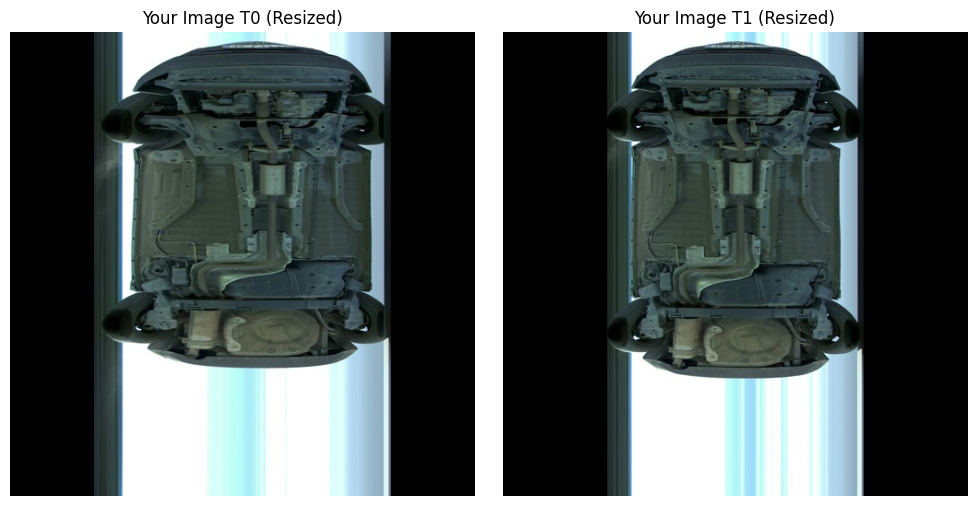

In [3]:
# Load your own images (without ROI masking)
# Replace these paths with your own image paths
my_image_root = "/home/divit/projects/photos/504"  # Change this to your image directory

# Load your image pair
my_t0 = plt.imread(os.path.join(my_image_root, "in.jpg"))[..., :3]  # Replace with your image names
my_t1 = plt.imread(os.path.join(my_image_root, "out.jpg"))[..., :3]  # Replace with your image names

# Ensure images are numpy arrays
my_t0 = np.asarray(my_t0)
my_t1 = np.asarray(my_t1)

print(f"Original image dimensions: {my_t0.shape[:2]}")
print(f"Image dtype: {my_t0.dtype}, range: [{my_t0.min():.3f}, {my_t0.max():.3f}]")

# Resize images to make dimensions divisible by 14 (for DinoV2)
def resize_to_multiple_of_14(image):
    h, w = image.shape[:2]
    
    # Check if already divisible by 14
    if h % 14 == 0 and w % 14 == 0:
        print(f"✓ Image already compatible: {h}x{w}")
        return image
    
    # Calculate new dimensions that are multiples of 14
    new_h = ((h // 14) + (1 if h % 14 != 0 else 0)) * 14
    new_w = ((w // 14) + (1 if w % 14 != 0 else 0)) * 14
    
    print(f"Resizing from {h}x{w} to {new_h}x{new_w}")
    
    # Convert to uint8 if needed
    if image.dtype != np.uint8:
        if image.max() <= 1.0:
            image_uint8 = (image * 255).astype(np.uint8)
        else:
            image_uint8 = image.astype(np.uint8)
    else:
        image_uint8 = image
    
    # Resize using OpenCV
    resized = cv2.resize(image_uint8, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    # Convert back to original dtype
    if image.dtype != np.uint8:
        if image.max() <= 1.0:
            resized = resized.astype(np.float32) / 255.0
        else:
            resized = resized.astype(image.dtype)
    
    return resized

# Resize both images
my_t0 = resize_to_multiple_of_14(my_t0)
my_t1 = resize_to_multiple_of_14(my_t1)

# Display your images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(my_t0)
ax[1].imshow(my_t1)
ax[0].set_title("Your Image T0 (Resized)")
ax[1].set_title("Your Image T1 (Resized)")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

# Check image dimensions (should be divisible by 14 for DinoV2)
H, W = my_t0.shape[:2]
print(f"Final image dimensions: {H}x{W}")
print(f"H % 14: {H % 14}, W % 14: {W % 14}")
print(f"✓ Ready for DinoV2!" if H % 14 == 0 and W % 14 == 0 else "❌ Still not compatible")

Converting images to tensors...
Tensor shapes: torch.Size([1, 3, 504, 504]), torch.Size([1, 3, 504, 504])
Tensor ranges: [0.000, 1.000]
Running inference...
Model output shapes: torch.Size([1, 504, 504, 2]), torch.Size([1, 504, 504, 2])
Model output device: cuda:0
Tensor shapes: torch.Size([1, 3, 504, 504]), torch.Size([1, 3, 504, 504])
Tensor ranges: [0.000, 1.000]
Running inference...
Model output shapes: torch.Size([1, 504, 504, 2]), torch.Size([1, 504, 504, 2])
Model output device: cuda:0
Converting predictions to numpy...
✓ Prediction shapes: (504, 504), (504, 504)
Inference completed! Visualizing results...
Converting predictions to numpy...
✓ Prediction shapes: (504, 504), (504, 504)
Inference completed! Visualizing results...


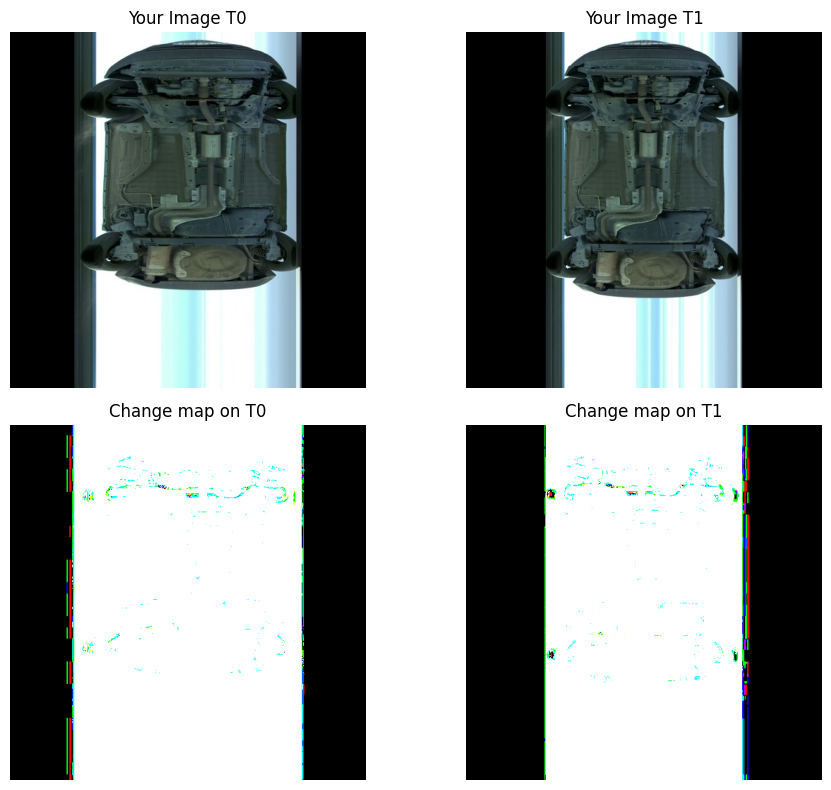

In [8]:
# Inference on your images (no ROI masking)
# Update model upsampling size for your images
my_model.module.upsample.size = (H, W)

# Ensure images are proper numpy arrays and normalize if needed
def prepare_tensor(image):
    """Convert image to proper tensor format"""
    # Ensure it's a numpy array and make a copy
    img_array = np.array(image, dtype=np.float32)
    
    # Normalize to [0, 1] if needed
    if img_array.max() > 1.0:
        img_array = img_array / 255.0
    
    # Ensure the array is contiguous in memory
    img_array = np.ascontiguousarray(img_array)
    
    # Convert to tensor using torch.tensor instead of torch.from_numpy
    tensor = torch.tensor(img_array, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    return tensor.cuda()

def tensor_to_numpy_safe(tensor):
    """Safely convert tensor to numpy, working around compatibility issues"""
    try:
        # Method 1: Standard conversion
        return tensor.numpy()
    except RuntimeError:
        try:
            # Method 2: Clone then convert
            return tensor.clone().numpy()
        except RuntimeError:
            try:
                # Method 3: Convert via list
                tensor_list = tensor.tolist()
                return np.array(tensor_list)
            except Exception:
                # Method 4: Manual conversion using tensor data
                if tensor.dim() == 0:  # scalar tensor
                    return float(tensor.item())
                else:
                    # For multi-dimensional tensors, convert via CPU first
                    cpu_tensor = tensor.detach().cpu()
                    # Use torch.Tensor.storage() approach
                    shape = cpu_tensor.shape
                    data = [float(cpu_tensor.flatten()[i]) for i in range(cpu_tensor.numel())]
                    return np.array(data).reshape(shape)

# Convert to tensors with proper handling
print("Converting images to tensors...")
my_tensor_0 = prepare_tensor(my_t0)
my_tensor_1 = prepare_tensor(my_t1)

print(f"Tensor shapes: {my_tensor_0.shape}, {my_tensor_1.shape}")
print(f"Tensor ranges: [{my_tensor_0.min():.3f}, {my_tensor_0.max():.3f}]")

# Run inference
print("Running inference...")
with torch.no_grad():
    my_pred_0 = my_model(my_tensor_0, my_tensor_1)  # 1, H, W, 2
    my_pred_1 = my_model(my_tensor_1, my_tensor_0)  # 1, H, W, 2
    
    print(f"Model output shapes: {my_pred_0.shape}, {my_pred_1.shape}")
    print(f"Model output device: {my_pred_0.device}")

    # Apply argmax and move to CPU
    pred_0_cpu = torch.argmax(my_pred_0, dim=-1).squeeze().detach().cpu()
    pred_1_cpu = torch.argmax(my_pred_1, dim=-1).squeeze().detach().cpu()
    
    # Convert to numpy using safe method
    print("Converting predictions to numpy...")
    my_pred_0 = tensor_to_numpy_safe(pred_0_cpu)
    my_pred_1 = tensor_to_numpy_safe(pred_1_cpu)
    
    print(f"✓ Prediction shapes: {my_pred_0.shape}, {my_pred_1.shape}")

print("Inference completed! Visualizing results...")

# Visualize results
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0, 0].imshow(my_t0)
ax[0, 1].imshow(my_t1)
ax[1, 0].imshow(utils_img.overlay_image(my_t0, [1, 0, 0], mask=my_pred_0))
ax[1, 1].imshow(utils_img.overlay_image(my_t1, [1, 0, 0], mask=my_pred_1))

ax[0, 0].set_title("Your Image T0")
ax[0, 1].set_title("Your Image T1")
ax[1, 0].set_title("Change map on T0")
ax[1, 1].set_title("Change map on T1")

# remove axis
for a in ax.ravel():
    a.axis("off")

plt.tight_layout()

---
Debug: Check what's inside your checkpoint file